In [2]:
import pandas as pd
import matplotlib as mlp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
trainingdf = pd.read_csv('/Users/florencecornelissen/Documents/VU/DMT/DMT2023_ass2/data/training_set_VU_DM.csv')
# startlen = len(trainingdf.index)

In [23]:
#Add column with day of the week
trainingdf['date_time'] = pd.to_datetime(trainingdf['date_time'])
trainingdf['weekday'] = trainingdf['date_time'].dt.dayofweek
# trainingdf['weekday_name'] = trainingdf['date_time'].dt.day_name()

#Add column with part of day: morning, afternoon, evening, night
trainingdf['part_of_day'] = pd.cut(trainingdf['date_time'].dt.hour,[0,6,12,18,24],labels=['night','morning','afternoon','evening'],include_lowest=True)

#Add column last minute whenever it is booked within 2 weeks upfront
trainingdf['last_minute'] = [1 if x <= 14 else 0 for x in trainingdf['srch_booking_window']]

#Fill NaN values from Gross_bookings_usd with 0
trainingdf['gross_bookings_usd'] = trainingdf['gross_bookings_usd'].fillna(0)

#If the price is outside the lower and upper quantile, replace it with the mean of the price of that hotel
trainingdf['price_usd'] = np.where((trainingdf['price_usd'] < trainingdf['price_usd'].quantile(0.001)) | (trainingdf['price_usd'] > trainingdf['price_usd'].quantile(0.999)), trainingdf.groupby('prop_country_id')['price_usd'].transform('mean'), trainingdf['price_usd'])

#Add 1 to all values in comp1_rate, comp2_rate etc. if they are not NaN so we get a range of 0 to 2 and calculated the total score of all competitors per prop_id (hotel)
columns = ['comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']
for column in columns:
    trainingdf[column] = trainingdf[column] + 1
    trainingdf['comp_rate'] = trainingdf.groupby('prop_id')[column].transform('mean')

#Add 1 to all values in comp1_inv, comp2_inv etc. if they are not NaN so we get a range of 0 to 2 and calculated the total score of all competitors per prop_id (hotel)
columns2 = ['comp1_inv', 'comp2_inv', 'comp3_inv', 'comp4_inv', 'comp5_inv', 'comp6_inv', 'comp7_inv', 'comp8_inv']
for column in columns2:
    trainingdf[column] = trainingdf[column] + 1
    trainingdf['comp_inv'] = trainingdf.groupby('prop_id')[column].transform('mean')

#Add 1 to all values in comp1_inv, comp2_inv etc. if they are not NaN so we get a range of 0 to 2 and calculated the total score of all competitors per prop_id (hotel)
columns2 = ['comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff']
for column in columns2:
    trainingdf['comp_rate_percent_diff'] = trainingdf.groupby('prop_id')[column].transform('mean')

#Get the date of the booking by adding the srch_booking_window to the date_time
trainingdf['date_booking'] = trainingdf['date_time'] + pd.to_timedelta(trainingdf['srch_booking_window'], unit='d')

#Add the price per night
trainingdf['price_per_night'] = trainingdf['price_usd'] / trainingdf['srch_length_of_stay']

def season_booking(row):
    month = row['date_booking'].month
    day = row['date_booking'].day

    if (month == 3 and day >= 21) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return 'spring'
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 21):
        return 'summer'
    elif (month == 9 and day >= 21) or (month == 10) or (month == 11) or (month == 12 and day < 21):
        return 'autumn'
    else:
        return 'winter'

#Get the season of the date_booking by the function season_booking
trainingdf['season_booking'] = trainingdf.apply(season_booking, axis=1)

#Drop the date_bookking again since we don't need it anymore
trainingdf.drop(['date_booking'], axis=1, inplace=True)


In [155]:
#Needs to be run after rows are dropped
#Based on the occurences of the srch_id in the temporal time, add 1 to the column if click_bool is 1 and 0 if click_bool is 0 over the whole dataset
#trainingdf['click_history'] = trainingdf.groupby('srch_id')['click_bool'].transform(lambda x: x.cumsum().shift())

In [15]:
trainingdf['price_per_night'].describe()

count    4.958347e+06
mean     9.605482e+01
std      1.145944e+03
min      1.534091e-01
25%      4.034667e+01
50%      7.152500e+01
75%      1.189300e+02
max      1.173038e+06
Name: price_per_night, dtype: float64

In [8]:
#If the price is outside the lower and upper quantile, replace it with the mean of the price of that hotel
trainingdf['price_usd'] = np.where((trainingdf['price_usd'] < trainingdf['price_usd'].quantile(0.001)) | (trainingdf['price_usd'] > trainingdf['price_usd'].quantile(0.999)), trainingdf.groupby('prop_id')['price_usd'].transform('mean'), trainingdf['price_usd'])

In [22]:
#calculate the number of click_bool before the booking_bool is 1 per srch_id
trainingdf['click_bool_before_booking'] = trainingdf.groupby('srch_id', group_keys=False)['click_bool'].apply(lambda x: x.cumsum().shift())

trainingdf['click_bool_before_booking'] = trainingdf['click_bool_before_booking'].where(trainingdf['booking_bool'] != 1, 0)

In [17]:
#Print number of records per search id
print(trainingdf.groupby('srch_id').size())

srch_id
1         28
4         32
6          5
8         21
11        33
          ..
332777    32
332781    15
332782    24
332784    28
332785     6
Length: 199795, dtype: int64


/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_4692/4225714963.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  click_count = trainingdf.groupby('srch_id')['click_bool'].apply(lambda x: x.cumsum().shift().fillna(0))


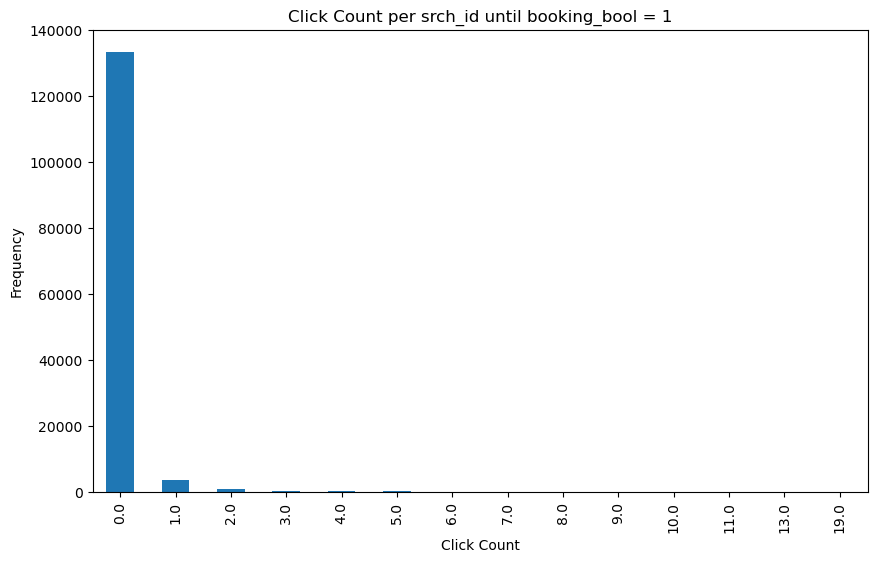

27         0
59         0
64         0
85         0
118        0
          ..
4958273    0
4958288    0
4958312    0
4958340    0
4958346    0
Name: booking_bool, Length: 199795, dtype: int64


In [ ]:
#Calculate the number of click_bool = 1 till booking_bool = 1 per srch_id
trainingdf['click_bool_till_booking'] = trainingdf.groupby('srch_id')['click_bool'].transform(lambda x: x.cumsum().shift())